# ASSIGNMENT 4
##  Classification Empirical Study Text Classification



---



 **Group Description**

- Group Number: 69
- Member 1
  - Student Name: Meet Mehta
  - Student Number: 300261159
- Member 2
  - Student Name: Rakshita Mathur
  - Student Number: 300215340




---



## Importing Libraries

In [ ]:
!pip install spacy

import spacy
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix



---



## Loading Dataset

I chose dataset 3 for its relevance to real-world applications, specifically in understanding and improving the passenger journey within the airline industry. The comprehensive collection of passenger reviews and corresponding categories provides valuable insights into customer satisfaction and service quality. This dataset aligns with my interest in practical applications and offers opportunities for meaningful analysis and informed decision-making.

In [ ]:
#Loading and reading the dataset
url = "https://raw.githubusercontent.com/rakshita003/Datasets/main/reduced_file_AirPassengerReviews.csv"
data = pd.read_csv(url)
data.head()

,customer_review,NPS Score
0,London to Izmir via Istanbul. First time I'd ...,Passive
1,Istanbul to Bucharest. We make our check in i...,Detractor
2,Rome to Prishtina via Istanbul. I flew with t...,Detractor
3,Flew on Turkish Airlines IAD-IST-KHI and retu...,Promoter
4,Mumbai to Dublin via Istanbul. Never book Tur...,Detractor




---



## Data Preprocessing

 The spacy library is used to tokenize the customer reviews.
 Three dataframes (dataset, derived_dataset1, and derived_dataset2) are created to store different types of processed data.


In [ ]:
# This is where you create the NLP pipeline. load() will download the correct model (English).
nlp = spacy.load("en_core_web_sm")

In [ ]:
#Apply nlp pipeline to the column that has your sentences.
data['tokenized'] = data['customer_review'].apply(nlp)

In [ ]:
data.head()

,customer_review,NPS Score,tokenized
0,London to Izmir via Istanbul. First time I'd ...,Passive,"( , London, to, Izmir, via, Istanbul, ., First..."
1,Istanbul to Bucharest. We make our check in i...,Detractor,"( , Istanbul, to, Bucharest, ., We, make, our,..."
2,Rome to Prishtina via Istanbul. I flew with t...,Detractor,"( , Rome, to, Prishtina, via, Istanbul, ., I, ..."
3,Flew on Turkish Airlines IAD-IST-KHI and retu...,Promoter,"( , Flew, on, Turkish, Airlines, IAD, -, IST, ..."
4,Mumbai to Dublin via Istanbul. Never book Tur...,Detractor,"( , Mumbai, to, Dublin, via, Istanbul, ., Neve..."


**Creating Empty Dataframes**

In [ ]:
dataset = pd.DataFrame(columns = ['Class', 'tokens'])
derived_dataset1 = pd.DataFrame(columns = ['Class', 'pos'])
derived_dataset2 = pd.DataFrame(columns = ['Class', 'pos-np'])

### Preporcessing dataset

In [ ]:
dataset['tokens'] = data['tokenized']
dataset['Class'] = data['NPS Score']

In [ ]:
dataset.head()

,Class,tokens
0,Passive,"( , London, to, Izmir, via, Istanbul, ., First..."
1,Detractor,"( , Istanbul, to, Bucharest, ., We, make, our,..."
2,Detractor,"( , Rome, to, Prishtina, via, Istanbul, ., I, ..."
3,Promoter,"( , Flew, on, Turkish, Airlines, IAD, -, IST, ..."
4,Detractor,"( , Mumbai, to, Dublin, via, Istanbul, ., Neve..."


In [ ]:
# Convert Spacy Doc objects to strings
X_strings = [" ".join([token.text for token in doc]) for doc in dataset['tokens']]

# Split the dataset into features (X) and labels (y)
X = X_strings  # Use the converted strings
y = dataset['Class']

# Encode the target labels using LabelEncoder
label_encoder = LabelEncoder()
y_encoded_dataset = label_encoder.fit_transform(y)

# Create a TfidfVectorizer to transform text data into numerical features
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf_dataset = tfidf_vectorizer.fit_transform(X)

### Preposcessing derived_dataset1

In [ ]:
def get_pos(sentence, wanted_pos): #wanted_pos refers to the desired pos tagging
    verbs = []
    for token in sentence:
        if token.pos_ in wanted_pos:
            verbs.append(token.lemma_) # lemma returns a number. lemma_ return a string
    return ' '.join(verbs) # return value is as a string and not a list for countVectorizer

In [ ]:
# we use the above function to fetch all the verbs. We store this information in our first derived dataset
derived_dataset1['pos'] = data['tokenized'].apply(lambda sent : get_pos(sent, ['VERB']))
derived_dataset1['Class'] = data['NPS Score']

In [ ]:
derived_dataset1.head()

,Class,pos
0,Passive,fly find delay miss speak give speak get make ...
1,Detractor,make take go let ™ say overbooke have wait bring
2,Detractor,fly say get fly have try ask connect relax lan...
3,Promoter,return maintain fly leave use seem have show h...
4,Detractor,travel get have ask stay care make keep wait


In [ ]:
# Split the dataset into features (X) and labels (y)
X1 = derived_dataset1['pos']
y1 = derived_dataset1['Class']

# Encode the target labels using LabelEncoder
label_encoder = LabelEncoder()
y_encoded_derived_dataset1 = label_encoder.fit_transform(y1)

# Create a TfidfVectorizer to transform text data into numerical features
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf_derived_dataset1 = tfidf_vectorizer.fit_transform(X1)

### Preporcessing derived_dataset2

In [ ]:
def get_named_entities_and_pos(sentence):
    entities = []
    selected_entities = [ 'ORG', 'GPE', 'MONEY', 'DATE']
    pos_tags = ['NOUN', 'ADJ']

    doc = nlp(sentence)

    # Extract named entities
    for ent in doc.ents:
        if ent.label_ in selected_entities:
            entities.append(ent.text)
            entities.append(ent.label_)

    # Extract POS tags
    pos_tokens = [token.lemma_ for token in doc if token.pos_ in pos_tags]
    entities.extend(pos_tokens)

    return ' '.join(entities)

In [ ]:
# Apply the function to create Derived-Dataset-2
derived_dataset2['pos-np'] = data['customer_review'].apply(lambda sent: get_named_entities_and_pos(sent))

# Assign 'NPS Score' to 'Class' column
derived_dataset2['Class'] = data['NPS Score']

In [ ]:
derived_dataset2.head()

,Class,pos-np
0,Passive,London GPE Istanbul GPE LHR ORG Istanbul GPE U...
1,Detractor,Istanbul GPE check airport luggage gate gate s...
2,Detractor,Rome GPE Prishtina GPE Istanbul GPE the past y...
3,Promoter,Turkish Airlines ORG Turkish Airlines ORG 2007...
4,Detractor,Mumbai GPE Dublin GPE Istanbul GPE Dublin GPE ...


In [ ]:
# Split the dataset into features (X) and labels (y)
X2 = derived_dataset2['pos-np']
y2 = derived_dataset2['Class']

# Encode the target labels using LabelEncoder
label_encoder = LabelEncoder()
y_encoded_derived_dataset2 = label_encoder.fit_transform(y2)

# Create a TfidfVectorizer to transform text data into numerical features
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf_derived_dataset2 = tfidf_vectorizer.fit_transform(X2)

In [ ]:
warnings.filterwarnings("ignore")



---



## Building different Models

The function builds and evaluates several machine learning models using different datasets.

Three main datasets are used (dataset, derived_dataset1, and derived_dataset2), and logistic regression and multilayer perceptron (MLP) models are applied to each dataset with variations in hyperparameters (e.g., hidden layer size and activation function).

Evaluation metrics such as precision, recall, F1-score, and accuracy are calculated for each model using stratified 4-fold cross-validation. Confusion matrices are plotted for each model.


In [ ]:
# Function to evaluate model and print metrics
a = {}

def evaluate_model(model, X, y, model_name, counter):
    # Initialize StratifiedKFold for cross-validation
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    # Lists to store results for each fold
    precision_micro_list, recall_micro_list, fscore_micro_list, accuracy_list = [], [], [], []
    precision_macro_list, recall_macro_list, fscore_macro_list = [], [], []

    # Iterate over folds in StratifiedKFold
    for train_index, test_index in skf.split(X, y):
        # Split dataset into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Fit the model on the training data
        model.fit(X_train, y_train)

        # Predict on the testing data
        y_pred = model.predict(X_test)

        # Calculate metrics for each fold
        precision_micro, recall_micro, fscore_micro, _ = precision_recall_fscore_support(y_test, y_pred, average='micro')
        precision_macro, recall_macro, fscore_macro, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
        accuracy = accuracy_score(y_test, y_pred)

        # Append metrics to respective lists
        precision_micro_list.append(precision_micro)
        recall_micro_list.append(recall_micro)
        fscore_micro_list.append(fscore_micro)
        accuracy_list.append(accuracy)

        precision_macro_list.append(precision_macro)
        recall_macro_list.append(recall_macro)
        fscore_macro_list.append(fscore_macro)

    # Calculate and print micro averages
    avg_precision_micro = np.mean(precision_micro_list)
    avg_recall_micro = np.mean(recall_micro_list)
    avg_fscore_micro = np.mean(fscore_micro_list)
    avg_accuracy = np.mean(accuracy_list)

    print(f"\nMicro Averages for {model_name}:")
    print(f"Average Precision (Micro): {avg_precision_micro:.2f}")
    print(f"Average Recall (Micro): {avg_recall_micro:.2f}")
    print(f"Average F1-score (Micro): {avg_fscore_micro:.2f}")

    # Calculate and print macro averages
    avg_precision_macro = np.mean(precision_macro_list)
    avg_recall_macro = np.mean(recall_macro_list)
    avg_fscore_macro = np.mean(fscore_macro_list)

    print(f"\nMacro Averages for {model_name}:")
    print(f"Average Precision (Macro): {avg_precision_macro:.2f}")
    print(f"Average Recall (Macro): {avg_recall_macro:.2f}")
    print(f"Average F1-score (Macro): {avg_fscore_macro:.2f}")

    # Print average accuracy
    print(f"\nAverage Accuracy for {model_name}:")
    print(f"Average Accuracy: {avg_accuracy:.2f}")
    temp = "Experiment "+str(counter)
    a[temp]  = avg_accuracy

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()


# Models Used

#### 1. Logistic Regression:
`
LogisticRegression(random_state=42, max_iter=1000)
`
- **Purpose:** Logistic Regression is a linear model used for binary and multiclass classification tasks.
- **Parameters:**
  - `random_state=42`: It ensures reproducibility by initializing the random number generator.
  - `max_iter=1000`: Maximum number of iterations for the solver to converge. It is set to a higher value (1000) to ensure convergence.
- **Explanation:**
 Logistic Regression is a linear model that works well for linearly separable problems.

#### 2. MLPClassifier (Default Parameters):
`
MLPClassifier(random_state=42, max_iter=500)
`
- **Purpose:** MLPClassifier is a Multilayer Perceptron (MLP) model, which is a type of neural network used for various machine learning tasks.
- **Parameters:**
  - `random_state=42`: Ensures reproducibility by initializing the random number generator.
  - `max_iter=500`: Maximum number of iterations for optimization algorithms. It helps control the training time.
- **Explanation:**
MLPClassifier is a neural network model capable of handling complex, non-linear relationships.

#### 3. MLPClassifier with Hidden Layer Sizes:
`
MLPClassifier(hidden_layer_sizes=(100, 50, 25), random_state=42)
`
- **Purpose:** Similar to the MLPClassifier, but with a specific architecture defined by the hidden layer sizes.
- **Parameters:**
  - `hidden_layer_sizes=(100, 50, 25)`: Three hidden layers with 100, 50, and 25 neurons, respectively. Specifies the size of each hidden layer.
- **Explanation:**
The third model has a specific architecture with three hidden layers and different neuron sizes.

#### 4. MLPClassifier with Logistic Activation and lbfgs Solver:
`
MLPClassifier(activation='logistic', random_state=42, solver='lbfgs')
`
- **Purpose:** MLPClassifier with a logistic activation function and lbfgs solver.
- **Parameters:**
  - `activation='logistic'`: Specifies the logistic (sigmoid) activation function for hidden layers.
  - `random_state=42`: Ensures reproducibility by initializing the random number generator.
  - `solver='lbfgs'`: Optimization algorithm for weight optimization. lbfgs is suitable for small datasets.
- **Explanation:**
The fourth model uses a logistic activation function and lbfgs solver, suitable for small datasets.




---



# Experiments

**Experiment 1: Logistic regression on dataset**


Micro Averages for Logistic Regression on dataset:
Average Precision (Micro): 0.79
Average Recall (Micro): 0.79
Average F1-score (Micro): 0.79

Macro Averages for Logistic Regression on dataset:
Average Precision (Macro): 0.71
Average Recall (Macro): 0.68
Average F1-score (Macro): 0.67

Average Accuracy for Logistic Regression on dataset:
Average Accuracy: 0.79


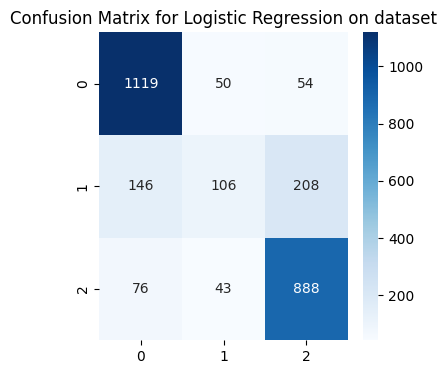

In [ ]:
# 1. Logistic Regression Model on dataset
lr_model1 = LogisticRegression(random_state=42, max_iter=1000)
evaluate_model(lr_model1, X_tfidf_dataset, y_encoded_dataset, "Logistic Regression on dataset",1 )

**Experiment 2: Multilayer Perceptron Model on dataset**


Micro Averages for MLP on dataset:
Average Precision (Micro): 0.76
Average Recall (Micro): 0.76
Average F1-score (Micro): 0.76

Macro Averages for MLP on dataset:
Average Precision (Macro): 0.68
Average Recall (Macro): 0.67
Average F1-score (Macro): 0.67

Average Accuracy for MLP on dataset:
Average Accuracy: 0.76


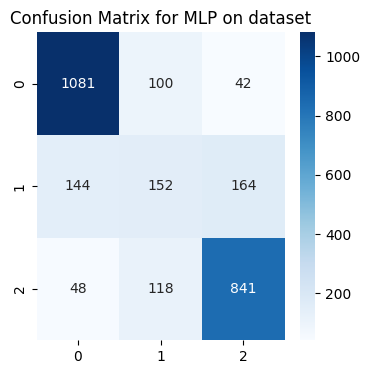

In [ ]:
# 2. Multilayer Perceptron Model on dataset
mlp_model2 = MLPClassifier(random_state=42, max_iter=500)
evaluate_model(mlp_model2, X_tfidf_dataset, y_encoded_dataset, "MLP on dataset", 2)

**Experiment 3: MLP with changed hidden layer size on dataset**


Micro Averages for MLP with hidden_layer_sizes (100, 50, 25) on dataset:
Average Precision (Micro): 0.76
Average Recall (Micro): 0.76
Average F1-score (Micro): 0.76

Macro Averages for MLP with hidden_layer_sizes (100, 50, 25) on dataset:
Average Precision (Macro): 0.69
Average Recall (Macro): 0.69
Average F1-score (Macro): 0.69

Average Accuracy for MLP with hidden_layer_sizes (100, 50, 25) on dataset:
Average Accuracy: 0.76


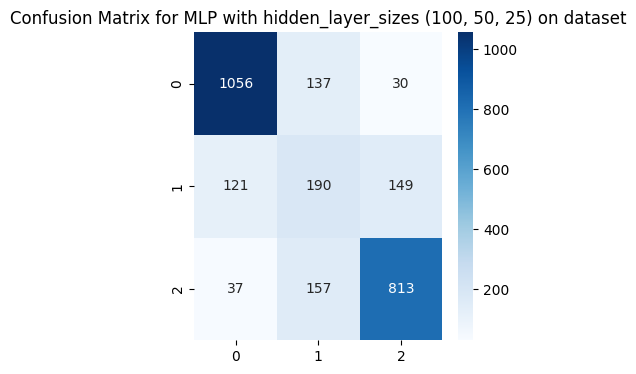

In [ ]:
# 3. MLP with changed hidden layer size on dataset
mlp_model_exp3 = MLPClassifier(hidden_layer_sizes=(100, 50, 25), random_state=42)
evaluate_model(mlp_model_exp3, X_tfidf_dataset, y_encoded_dataset, "MLP with hidden_layer_sizes (100, 50, 25) on dataset",3)

**Experiment 4: MLP with logistic activation function on dataset**


Micro Averages for MLP with logistic Activation Function on dataset:
Average Precision (Micro): 0.76
Average Recall (Micro): 0.76
Average F1-score (Micro): 0.76

Macro Averages for MLP with logistic Activation Function on dataset:
Average Precision (Macro): 0.68
Average Recall (Macro): 0.68
Average F1-score (Macro): 0.68

Average Accuracy for MLP with logistic Activation Function on dataset:
Average Accuracy: 0.76


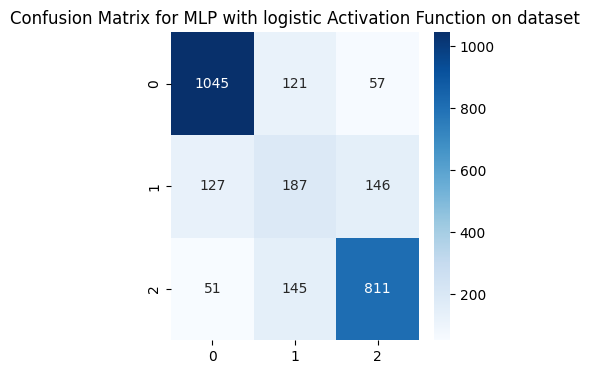

In [ ]:
 # 4. MLP with changed activation function on dataset
mlp_model_exp4 = MLPClassifier(activation='logistic', random_state=42 , solver = 'lbfgs')
evaluate_model(mlp_model_exp4, X_tfidf_dataset, y_encoded_dataset, "MLP with logistic Activation Function on dataset",4)

**Experiment 5: Logistic Regression Model on dereived_dataset1**


Micro Averages for Logistic Regression on derived_dataset1:
Average Precision (Micro): 0.68
Average Recall (Micro): 0.68
Average F1-score (Micro): 0.68

Macro Averages for Logistic Regression on derived_dataset1:
Average Precision (Macro): 0.58
Average Recall (Macro): 0.57
Average F1-score (Macro): 0.54

Average Accuracy for Logistic Regression on derived_dataset1:
Average Accuracy: 0.68


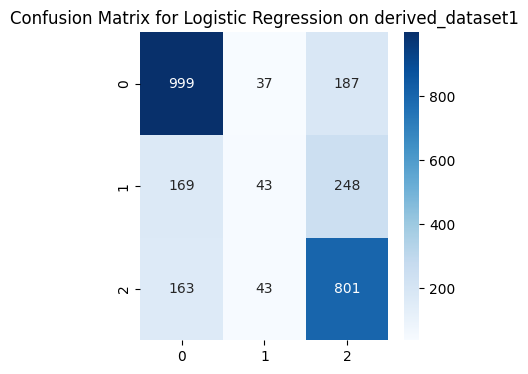

In [ ]:
# 5. Logistic Regression Model on dereived_dataset1
lr_model5 =LogisticRegression(random_state=42, max_iter=1000)
evaluate_model(lr_model5, X_tfidf_derived_dataset1, y_encoded_derived_dataset1, "Logistic Regression on derived_dataset1", 5)

**Experiment 6: Multilayer Perceptron Model on dereived_dataset1**


Micro Averages for MLP on derived_dataset1:
Average Precision (Micro): 0.63
Average Recall (Micro): 0.63
Average F1-score (Micro): 0.63

Macro Averages for MLP on derived_dataset1:
Average Precision (Macro): 0.55
Average Recall (Macro): 0.55
Average F1-score (Macro): 0.55

Average Accuracy for MLP on derived_dataset1:
Average Accuracy: 0.63


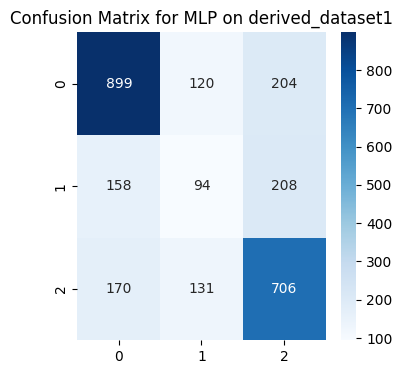

In [ ]:
 # 6. Multilayer Perceptron Model on dereived_dataset1
mlp_model6 = MLPClassifier(random_state=42, max_iter=500)
evaluate_model(mlp_model6, X_tfidf_derived_dataset1, y_encoded_derived_dataset1, "MLP on derived_dataset1",6)

**Experiment 7: MLP with changed hidden layer size on dereived_dataset1**


Micro Averages for MLP with hidden_layer_sizes (100, 50, 25) on derived_dataset1:
Average Precision (Micro): 0.63
Average Recall (Micro): 0.63
Average F1-score (Micro): 0.63

Macro Averages for MLP with hidden_layer_sizes (100, 50, 25) on derived_dataset1:
Average Precision (Macro): 0.54
Average Recall (Macro): 0.54
Average F1-score (Macro): 0.54

Average Accuracy for MLP with hidden_layer_sizes (100, 50, 25) on derived_dataset1:
Average Accuracy: 0.63


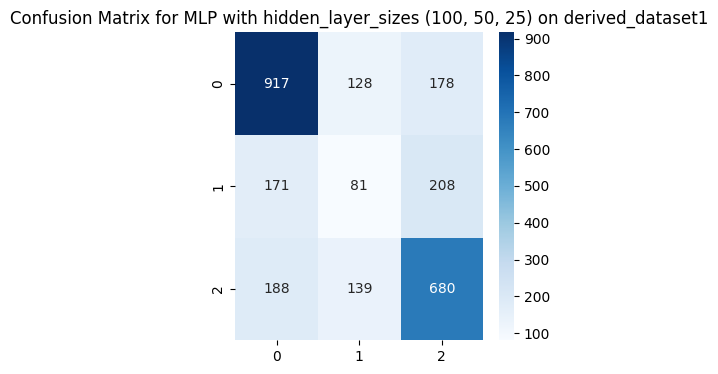

In [ ]:
# 7. MLP with changed hidden layer size on dereived_dataset1
mlp_model_exp7 = MLPClassifier(hidden_layer_sizes=(100, 50, 25), random_state=42)
evaluate_model(mlp_model_exp7, X_tfidf_derived_dataset1, y_encoded_derived_dataset1, "MLP with hidden_layer_sizes (100, 50, 25) on derived_dataset1",7)

**Experiment 8: MLP with Logistic activation function on dereived_dataset1**


Micro Averages for MLP with 'logistic' Activation Function on derived_dataset1:
Average Precision (Micro): 0.64
Average Recall (Micro): 0.64
Average F1-score (Micro): 0.64

Macro Averages for MLP with 'logistic' Activation Function on derived_dataset1:
Average Precision (Macro): 0.55
Average Recall (Macro): 0.55
Average F1-score (Macro): 0.55

Average Accuracy for MLP with 'logistic' Activation Function on derived_dataset1:
Average Accuracy: 0.64


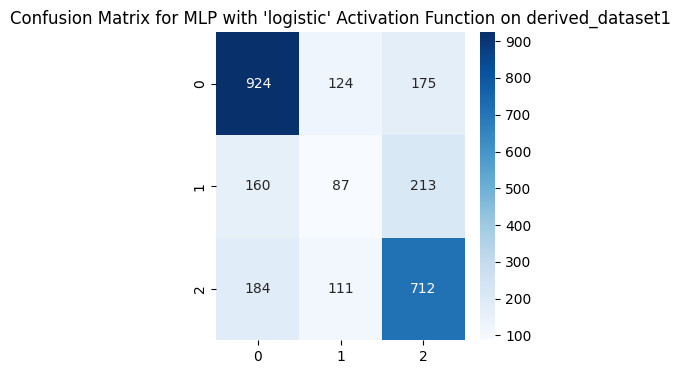

In [ ]:
# # 8. MLP with changed activation function on dereived_dataset1
mlp_model_exp8 = MLPClassifier(activation='logistic', random_state=42 , solver = 'lbfgs')
evaluate_model(mlp_model_exp8, X_tfidf_derived_dataset1, y_encoded_derived_dataset1, "MLP with 'logistic' Activation Function on derived_dataset1",8)

**Experiment 9: Logistic regression on dereived_dataset2**


Micro Averages for Logistic Regression on derived_dataset2:
Average Precision (Micro): 0.78
Average Recall (Micro): 0.78
Average F1-score (Micro): 0.78

Macro Averages for Logistic Regression on derived_dataset2:
Average Precision (Macro): 0.70
Average Recall (Macro): 0.67
Average F1-score (Macro): 0.66

Average Accuracy for Logistic Regression on derived_dataset2:
Average Accuracy: 0.78


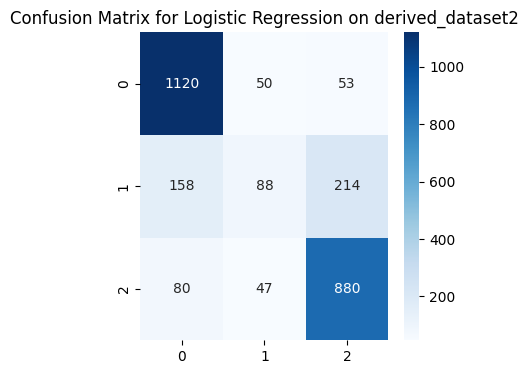

In [ ]:
# # 9. Logistic Regression Model on dereived_dataset2
lr_model9 = LogisticRegression(random_state=42, max_iter=1000)
evaluate_model(lr_model9, X_tfidf_derived_dataset2, y_encoded_derived_dataset2, "Logistic Regression on derived_dataset2", 9)

**Experiment 10. Multilayer Perceptron Model on dereived_dataset2**


Micro Averages for MLP on derived_dataset2:
Average Precision (Micro): 0.74
Average Recall (Micro): 0.74
Average F1-score (Micro): 0.74

Macro Averages for MLP on derived_dataset2:
Average Precision (Macro): 0.66
Average Recall (Macro): 0.65
Average F1-score (Macro): 0.65

Average Accuracy for MLP on derived_dataset2:
Average Accuracy: 0.74


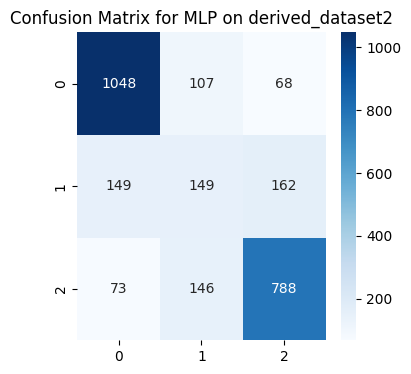

In [ ]:
# 10. Multilayer Perceptron Model on dereived_dataset2
mlp_model10 = MLPClassifier(random_state=42, max_iter=500)
evaluate_model(mlp_model10, X_tfidf_derived_dataset2, y_encoded_derived_dataset2, "MLP on derived_dataset2",10)

**Experiment 11. MLP with changed hidden layer size on dereived_dataset2**


Micro Averages for MLP with hidden_layer_sizes (100, 50, 25) on derived_dataset2:
Average Precision (Micro): 0.73
Average Recall (Micro): 0.73
Average F1-score (Micro): 0.73

Macro Averages for MLP with hidden_layer_sizes (100, 50, 25) on derived_dataset2:
Average Precision (Macro): 0.66
Average Recall (Macro): 0.65
Average F1-score (Macro): 0.66

Average Accuracy for MLP with hidden_layer_sizes (100, 50, 25) on derived_dataset2:
Average Accuracy: 0.73


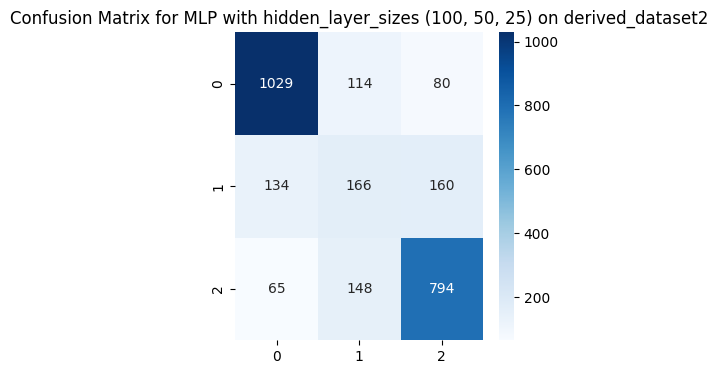

In [ ]:
# # 11. MLP with changed hidden layer size on dereived_dataset2
mlp_model_exp11 = MLPClassifier(hidden_layer_sizes=(100, 50, 25), random_state=42)
evaluate_model(mlp_model_exp11, X_tfidf_derived_dataset2, y_encoded_derived_dataset2, "MLP with hidden_layer_sizes (100, 50, 25) on derived_dataset2",11)

**Experiment 12. MLP with logistic activation function on dereived_dataset2**


Micro Averages for MLP with logistic Activation Function on derived_dataset2:
Average Precision (Micro): 0.73
Average Recall (Micro): 0.73
Average F1-score (Micro): 0.73

Macro Averages for MLP with logistic Activation Function on derived_dataset2:
Average Precision (Macro): 0.65
Average Recall (Macro): 0.65
Average F1-score (Macro): 0.65

Average Accuracy for MLP with logistic Activation Function on derived_dataset2:
Average Accuracy: 0.73


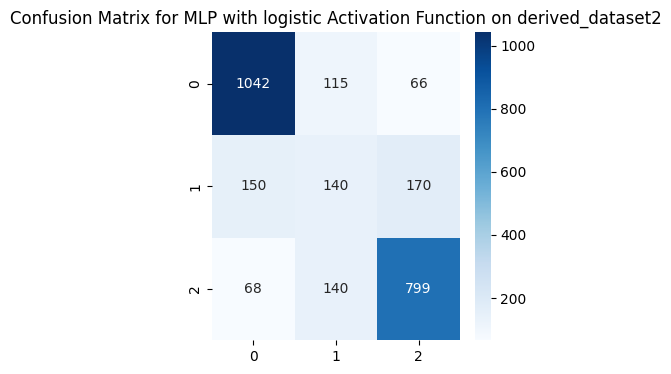

In [ ]:
# # 12. MLP with changed activation function on dereived_dataset2
mlp_model_exp12 = MLPClassifier(activation='logistic', random_state=42 , solver = 'lbfgs')
evaluate_model(mlp_model_exp12, X_tfidf_derived_dataset2, y_encoded_derived_dataset2, "MLP with logistic Activation Function on derived_dataset2",12)



---



# Quantitative analysis

In [ ]:
# Create a PrettyTable object to display the classification report in a tabular format
table = PrettyTable()

# Define column names and alignment for the table
table.field_names = ["Experiment #", 'Accuracy' ]
table.align["Experiment_type"] = "c"

# Add data to the table from the classification report
for Experiment_type, metrics in a.items():
  table.add_row([
      Experiment_type, metrics

  ])

# Print the formatted classification report table
print(table)

+---------------+--------------------+
|  Experiment # |      Accuracy      |
+---------------+--------------------+
|  Experiment 1 | 0.7893321950215437 |
|  Experiment 2 | 0.7634058661737667 |
|  Experiment 3 | 0.7567151070828136 |
|  Experiment 4 | 0.7588519973642004 |
|  Experiment 5 | 0.6819081296736057 |
|  Experiment 6 | 0.6342353141892498 |
|  Experiment 7 | 0.6268008189213943 |
|  Experiment 8 | 0.6386028949589642 |
|  Experiment 9 | 0.7790175568016201 |
| Experiment 10 | 0.7363641920818258 |
| Experiment 11 | 0.7339481805660891 |
| Experiment 12 | 0.7332977610899059 |
+---------------+--------------------+




---



# Conclusion

In this empirical study, we embarked on a comprehensive exploration of text classification using various models and datasets. The goal was to evaluate the performance of different models on original and derived datasets, shedding light on the impact of altering certain parameters on model outcomes. Here are the key findings and conclusions from our study:

1. Dataset Derivation:

  - `Original Dataset`: We started with the raw textual data, maintaining the original form for baseline comparison.
  
  - `Derived-Dataset-1`:This dataset was crafted to include lemmatized verbs, providing insight into the role of these parts of speech in classification.
  
  - `Derived-Dataset-2`: This dataset featured named entities along with selected parts of speech. We chose entities like organizations, money, and dates, aiming to capture specific information for more nuanced classification.

2. Model Selection and Training:

  - `Logistic Regression`:
A traditional yet effective model that served as a baseline for comparison.

  - `Multilayer Perceptron (MLP)`:
A more complex model capable of capturing intricate patterns in the data.

3. Model Variations:
  
    We experimented with the MLP model by altering its hidden layer size, model solver (using `lbfgs`), max_iteration, random_state and activation function (using `logistic`) to gauge the impact on performance.

4. Evaluation Metrics:

  Employed a 4-fold cross-validation technique for robust evaluation. Precision and recall measures were used, comparing micro and macro averages to account for potential class imbalances.

5. Results Analysis:

  Quantitative analysis of 12 results (4 models × 3 datasets) revealed variations in performance across different configurations. Changes in MLP parameters influenced model outcomes, highlighting the importance of parameter tuning.

6. Recommendations:

  The choice of the model and dataset should align with the specific task requirements and characteristics of the data. Further experimentation with hyperparameter tuning such as changing the solver, learning rate, activation function, hindder layers  and additional feature engineering could lead to improved results.

7. Overall Reflection:

  This empirical study provided valuable insights into the challenges and nuances of text classification. The iterative process of model selection, parameter tuning, and dataset derivation contributed to a deeper understanding of the underlying dynamics.

In conclusion, our study lays the groundwork for future exploration in text classification, emphasizing the need for thoughtful consideration of models, datasets, and parameters to achieve optimal results in real-world applications.



---



## Resources

- Airline passenger reviews. (2023, July 14). Kaggle. https://www.kaggle.com/datasets/malharkhatu/airline-passenger-reviews

- Logistic Regression using Python (scikit-learn) - Towards Data Science. Galarnyk, M. (2022, April 27)  Medium.
https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a

- GeeksforGeeks. (2020, August 18). Creating Tables with PrettyTable Library   Python.
 https://www.geeksforgeeks.org/creating-tables-with-prettytable-library-python/ -

- Navlani, A. (2019, December 16). Understanding logistic Regression in Python Tutorial.
https://www.datacamp.com/tutorial/understanding-logistic-regression-python

- sklearn.neural_network.MLPClassifier. (n.d.). Scikit-learn.
https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

- Working with text data. (n.d.). Scikit-learn.
https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html



---

